# План симуляций
0. Превышение критической энергии, условие  возникновения лавины.
1. Симуляции паратметров электронной лавины без учета гамма-квантов
2. Расчет длинны нарастания лавины для разных высот и полей (делая поправку для поля на высоту)
3. Расчет средней энергии электронов, спектра электронов, зависимости от начальной энергии




In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import tables
import matplotlib as mpl

In [1]:
path = "/home/zelenyy/data/thunderstorm/test/result.hdf5"
# path = "/mnt/storage2/phd/data/thunderstorm/critical_energy/result.hdf5"

In [11]:
with tables.open_file(path) as h5file:
    # print(h5file)
    for group in h5file.root:
        # print(group._v_name)
        table = h5file.get_node(group, "stacking_simple")
        # print(table.nrows)
        print(repr(table.attrs))
        # data = table.read()
        break

/sim0000/stacking_simple._v_attrs (AttributeSet), 31 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0,
    FIELD_0_NAME := 'event',
    FIELD_1_FILL := 0,
    FIELD_1_NAME := 'id',
    FIELD_2_FILL := 0,
    FIELD_2_NAME := 'parent_id',
    FIELD_3_FILL := 0,
    FIELD_3_NAME := 'particle',
    FIELD_4_FILL := 0.0,
    FIELD_4_NAME := 'energy',
    FIELD_5_FILL := 0.0,
    FIELD_5_NAME := 'theta',
    FIELD_6_FILL := 0.0,
    FIELD_6_NAME := 'radius',
    FIELD_7_FILL := 0.0,
    FIELD_7_NAME := 'z',
    FIELD_8_FILL := 0.0,
    FIELD_8_NAME := 'time',
    NROWS := 603,
    TITLE := '',
    VERSION := '2.7',
    path := 'sim0000',
    text := '/npm/geometry/type gdml\n/npm/geometry/gdml .././gdml/0.gdml\n/npm/thunderstorm/physics standard_opt_4\n/npm/thunderstorm/minimal_energy 0.10220286877494192 MeV\n/npm/thunderstorm/stacking/electron false\n/npm/thunderstorm/stacking/positron false\n/npm/thunderstorm/stacking/gamma false\n/npm/thunderstorm/stacking/save_gamma false\n/npm/thu

In [ ]:
bins = np.arange(0.001, 2, 0.001)


In [3]:
@dataclass
class CEData:
    number : int
    energy : float
    hist : np.ndarray

def select_data(table, field, height):
    m_field = table.attrs["values_gdml_field"][0]
    m_height = table.attrs["values_gdml_height"][0]
    return np.isclose([m_field, m_height], [field, height]).all()

def get_data(path, field = 0.0, height = 0.0):
    result = []
    bins = np.arange(0.001, 2, 0.001)
    with tables.open_file(path) as h5file:
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            if select_data(table, field, height):
                data = table.read()
                energy =  table.attrs["values_macros_energy"]
                number =  table.attrs["values_macros_number"]
                hist, _ = np.histogram(data["energy"], bins=bins)
                result.append(CEData(number, energy, hist))
    return result, bins

In [5]:
ce_list, bins = get_data(path, field=9e-4)

In [6]:
ce_list = sorted(ce_list, key=lambda x: x.energy)

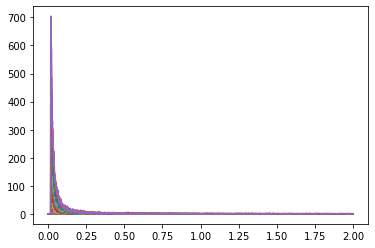

In [7]:
for item in ce_list:
    plt.step(bins[:-1], item.hist)

In [9]:
for item in ce_list:
    print(item.hist.sum()/item.number, ce_list.index(item))

0.0 0
0.0 1
0.0 2
0.0 3
0.0 4
0.0 5
0.0 6
0.0 7
0.0 8
0.0 9
0.0 10
0.0 11
0.0 12
0.0 13
0.0 14
0.0 15
0.0 16
0.0 17
0.0 18
0.0 19
0.0 20
0.02 21
0.0 22
0.01 23
0.06 24
0.0 25
0.02 26
0.02 27
8.08 28
0.06 29
0.07 30
7.14 31
0.07 32
7.19 33
34.08 34
6.33 35
14.28 36
0.12 37
21.76 38
21.16 39
27.0 40
20.58 41
35.33 42
28.43 43
53.41 44
33.91 45
93.42 46
57.15 47
74.94 48
91.7 49
93.36 50
133.88 51
119.67 52
141.23 53
149.68 54


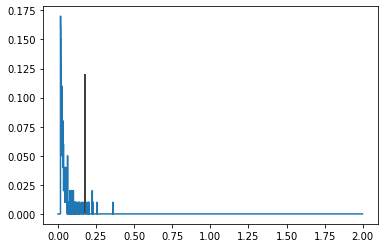

In [65]:
item = ce_list[-1]
n = 100
plt.step(bins[:-1], item.hist/item.number)
plt.vlines(item.energy, 0, 0.12)

In [4]:
def get_data_event(path, field = 0.0, height = 0.0):
    result = []
    with tables.open_file(path) as h5file:
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            if select_data(table, field, height):
                data = table.read()
                energy =  table.attrs["values_macros_energy"]
                number =  table.attrs["values_macros_number"]
                _, temp  = np.unique(data["event"], return_counts=True)
                result.append(CEData(number, energy, temp))
    return result

In [11]:
event_list = get_data_event(path, field=9e-4)

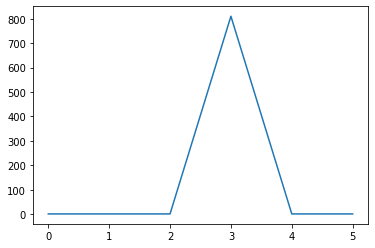

In [14]:
item = event_list[28]
plt.plot(item.hist)

In [9]:
def get_data_z(path, field = 0.0, height = 0.0):
    result = []
    bins = np.arange(-500.0, 501, 1)
    with tables.open_file(path) as h5file:
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            if select_data(table, field, height):
                data = table.read()
                energy =  table.attrs["values_macros_energy"]
                number =  table.attrs["values_macros_number"]
                temp, _ = np.histogram(data["z"], bins=bins)
                temp = np.cumsum(temp)
                result.append(CEData(number, energy, temp))
    return result

In [10]:
z_list = get_data_z(path, field=9e-4)


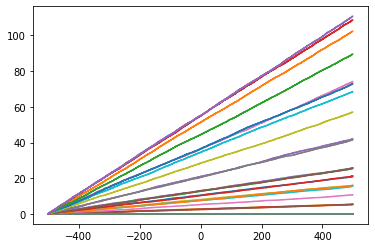

In [12]:
bins = np.arange(-500.0, 501, 1)
for item in z_list:
    plt.step(bins[:-1], item.hist/item.number)

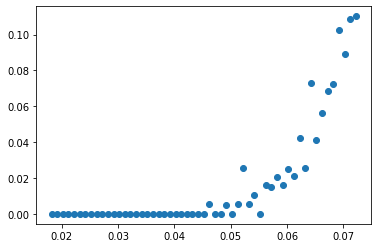

In [14]:
from scipy.linalg import lstsq

bins = np.arange(-500.0, 501, 1)
energy = []
k = []
for item in z_list:
    x = bins[:-1]
    y = item.hist/item.number
    M = x[:, np.newaxis]**[0, 1]
    p, res, rnk, s = lstsq(M, y)
    energy.append(item.energy)
    k.append(p[1])
plt.plot(energy, k, "o")

In [20]:
path = "/mnt/storage2/phd/data/thunderstorm/critical_energy/critical_energy.npy"
path = "/mnt/storage2/phd/data/thunderstorm/critical_energy/critical_energy_simple.npy"
#

In [26]:
data = np.load(path)

In [27]:
indx = np.logical_and(data["height"] == 5000.0, np.ma.masked_values(data["field"], 6.33333333e-04).mask)

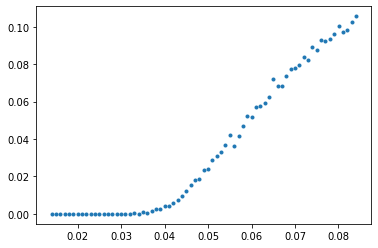

In [28]:
plt.plot(data["energy"][indx], data["k"][indx], ".")

In [17]:
x = data["energy"][indx]
y =  data["k"][indx]

In [7]:
import pandas as pd

In [8]:
df = pd.DataFrame(data)

In [13]:
np.unique(data[["height","field"]])

array([(    0., 3.00000000e-04), (    0., 3.88888889e-04),
       (    0., 4.77777778e-04), (    0., 5.66666667e-04),
       (    0., 6.55555556e-04), (    0., 7.44444444e-04),
       (    0., 8.33333333e-04), (    0., 9.22222222e-04),
       (    0., 1.01111111e-03), (    0., 1.10000000e-03),
       ( 1000., 2.00000000e-04), ( 1000., 2.88888889e-04),
       ( 1000., 3.77777778e-04), ( 1000., 4.66666667e-04),
       ( 1000., 5.55555556e-04), ( 1000., 6.44444444e-04),
       ( 1000., 7.33333333e-04), ( 1000., 8.22222222e-04),
       ( 1000., 9.11111111e-04), ( 1000., 1.00000000e-03),
       ( 2000., 2.00000000e-04), ( 2000., 2.77777778e-04),
       ( 2000., 3.55555556e-04), ( 2000., 4.33333333e-04),
       ( 2000., 5.11111111e-04), ( 2000., 5.88888889e-04),
       ( 2000., 6.66666667e-04), ( 2000., 7.44444444e-04),
       ( 2000., 8.22222222e-04), ( 2000., 9.00000000e-04),
       ( 3000., 2.00000000e-04), ( 3000., 2.77777778e-04),
       ( 3000., 3.55555556e-04), ( 3000., 4.33333333e-04

In [32]:
def get_data()
    result = []
    fh = np.unique(data[["height", "field"]], axis=0)
    for item in fh:
        height, field = item
        indx = np.logical_and(data["height"] == height, data["field"] == field)
        x = data["energy"][indx]
        y =  data["k"][indx]
        indx = (y > 0.001).argmax()
        result.append((height, field, x[indx]))

In [33]:
from mpl_toolkits.mplot3d import Axes3D

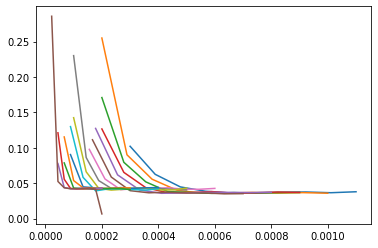

In [36]:
data_scatter = np.array(result)
heights = np.unique(fh["height"])
for height in heights:
    indx = data_scatter[:, 0] == height
    x = data_scatter[indx, 1]
    y = data_scatter[indx, 2]
    plt.plot(x,y)

In [2]:
path_1 = "/mnt/storage2/phd/data/thunderstorm/critical_energy/critical_energy.npy"
path_2 = "/mnt/storage2/phd/data/thunderstorm/critical_energy/critical_energy_simple.npy"

# Минимальное поле для убегания

In [6]:
path = "/home/zelenyy/data/thunderstorm/test/result.hdf5"

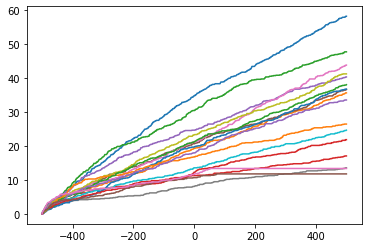

In [10]:
bins = np.arange(-500.0, 501, 1)
with tables.open_file(path) as h5file:
    # print(h5file)
    for group in h5file.root:
        # print(group._v_name)
        table = h5file.get_node(group, "stacking_simple")
        data = table.read()
        m_field = table.attrs["values_gdml_field"][0]
        m_height = table.attrs["values_gdml_height"][0]
        number =  table.attrs["values_macros_number"]
        temp, _ = np.histogram(data["z"], bins=bins)
        temp = np.cumsum(temp[::-1])/number

        plt.plot(bins[:-1], temp)

In [12]:
bins = np.arange(-500.0, 501, 1)
with tables.open_file(path) as h5file:
    result = []
    for group in h5file.root:
        # print(group._v_name)
        table = h5file.get_node(group, "stacking_simple")
        data = table.read()
        field = table.attrs["values_gdml_field"][0]
        height = table.attrs["values_gdml_height"][0]
        number =  table.attrs["values_macros_number"]
        ce = table.attrs["values_macros_min_energy"]
        result.append((height, field, table.nrows/number, ce))
    result.sort(key=lambda x: x[1])

for item in result:
    print(*item)

0.0 0.00020470466951619406 60.3 0.10220286877494192
0.0 0.0002108458096016799 37.7 0.10220286877494192
0.0 0.0002169869496871657 49.6 0.10220286877494192
0.0 0.00022312808977265153 17.7 0.10220286877494192
0.0 0.00022926922985813737 41.6 0.10220286877494192
0.0 0.0002354103699436232 37.9 0.10220286877494192
0.0 0.00024155151002910904 45.6 0.10220286877494192
0.0 0.00024769265011459485 13.7 0.10220286877494192
0.0 0.0002538337902000807 42.5 0.10220286877494192
0.0 0.0002599749302855665 25.8 0.10220286877494192
0.0 0.00026611607037105235 38.6 0.10220286877494192
0.0 0.0002722572104565382 27.4 0.10220286877494192
0.0 0.000278398350542024 40.6 0.10220286877494192
0.0 0.00028453949062750986 22.3 0.10220286877494192
0.0 0.0002906806307129957 34.8 0.10220286877494192
0.0 0.0002968217707984815 11.8 0.10220286877494192
0.0 0.0003029629108839673 13.4 0.0625584577292022
